In [0]:
# Save the model
# model.model.save('chars_i40.h5')

# Recreate the exact same model purely from the file
# new_model = keras.models.load_model('path_to_my_model.h5')

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
print("GPU:", tf.test.gpu_device_name())
import numpy as np

TensorFlow 2.x selected.
Tensorflow version: 2.0.0
GPU: /device:GPU:0


In [0]:
!git clone https://github.com/michalovsky/books-data.git

Cloning into 'books-data'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 79 (delta 20), reused 57 (delta 13), pack-reused 0
Unpacking objects: 100% (79/79), done.


In [0]:
import glob

def read_data(directory):
  file_paths = glob.glob(directory +"*.txt")    
  text = ""
  for file_path in file_paths:
    with open(file_path, 'r', encoding="utf-8-sig") as file:
      file_content = file.read()
      text+=file_content
  return text

directory1 = "books-data/kafka/"
directory2 = "books-data/shelley/"
directory3 = "books-data/defoe/"
directory4 = "books-data/plato/"

text = read_data(directory1)
print ('Length of text: {} characters'.format(len(text)))

Length of text: 571642 characters


In [0]:
import string

class DataProcessor:
	def __init__(self, chars_to_remove, chars_to_translate, replacement_chars):
		self.chars_to_remove = chars_to_remove
		self.chars_to_translate = chars_to_translate
		self.replacement_chars = replacement_chars

	def preprocess_data(self, text):
		removal_translator = str.maketrans("", "", self.chars_to_remove)
		special_characters_translator = str.maketrans(self.chars_to_translate, self.replacement_chars , '')
		text = text.lower().translate(removal_translator).translate(special_characters_translator)
		text = " ".join(text.split())
		return text

characters_to_remove = '–—”„…«»‘’“°ſ†•✠' + '!\"#$%&\'()*+-/:;<=>?@[\]^_`{|}~' + string.digits  
characters_to_translate = 'ąćęłńóśźżäöüæèêéôâáà£çëîñòùúûāœï'
replacement_characters = 'acelnoszzaoueeeeoaaaeceinouuuaei'

dataprocessor = DataProcessor(characters_to_remove, characters_to_translate, replacement_characters)
text = dataprocessor.preprocess_data(text)

vocab = sorted(list(set(text)))
print ('{} unique characters:'.format(len(vocab)))
print(vocab)
vocab_size = len(vocab)

29 unique characters:
[' ', ',', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [0]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from random import randint

char_to_indices = dict((c, i) for i, c in enumerate(vocab))
indices_to_char = dict((i, c) for i, c in enumerate(vocab))

class Dataset:
  def __init__(self):
    self.text_sequences = list()
    self.X_train = list()
    self.y_train = list()
    self.X_val = list()
    self.y_val = list()

  def make_dataset(self, text, sequence_length=40):
    sequences = list()
    labels = list()
    encoded_chars = np.array([char_to_indices[ch] for ch in text]) 
    for i in range(0, len(encoded_chars) - sequence_length, 1):
        sequences.append(encoded_chars[i:i + sequence_length])
        self.text_sequences.append(text[i:i + sequence_length])
        labels.append(encoded_chars[i + sequence_length])
    X = np.reshape(sequences, (len(sequences), sequence_length, 1))
    X = np_utils.to_categorical(X)
    y = np_utils.to_categorical(labels)
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X, y, test_size=0.2, shuffle=True)
    return self

  def get_random_sequence(self):
	  return self.text_sequences[randint(0, len(self.text_sequences))]

input_sequence_length = 40
dataset = Dataset().make_dataset(text, input_sequence_length)

Using TensorFlow backend.


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Embedding
from tensorflow.keras.constraints import max_norm

class Model:
  def __init__(self):
    self.model = Sequential()
    self.__build_model()
    self.__compile_model()
    self.model.summary()

  def __build_model(self):
    self.model.add(LSTM(90, input_shape=(input_sequence_length, vocab_size),return_sequences=True, recurrent_initializer='glorot_uniform'))
    self.model.add(LSTM(90, recurrent_initializer='glorot_uniform'))
    self.model.add(Dense(vocab_size, activation='softmax'))

  def __compile_model(self):
    self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  def fit_model(self, X_train, y_train, validation_data, epochs, batch_size, callbacks):
    return self.model.fit(
        X_train,
        y_train,
        validation_data=validation_data,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        callbacks=callbacks
    )

model = Model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 90)            43200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 90)                65160     
_________________________________________________________________
dense (Dense)                (None, 29)                2639      
Total params: 110,999
Trainable params: 110,999
Non-trainable params: 0
_________________________________________________________________


In [0]:
import sys

def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_text(model, seed, characters_amount=100):
    print('Generating with seed: "' + seed + '"')
    
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('Diversity:', diversity)
        sentence = seed
        generated = ''
        generated += sentence
        sys.stdout.write(generated)

        for i in range(characters_amount):
            x_pred = np.zeros((1, input_sequence_length, vocab_size))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_to_indices[char]] = 1.
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_to_char[next_index]
            sentence = sentence[1:] + next_char
            sys.stdout.write(next_char)
            if next_char=='.':
              sys.stdout.write("\n")
            sys.stdout.flush()
        print()


In [0]:
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, Callback

seed_for_epochs = dataset.get_random_sequence()
print("Checking with seed:", seed_for_epochs)

def on_epoch_end(epoch, _):
    print()
    generate_text(model.model, seed=seed_for_epochs, characters_amount=100)
    print()

text_generation = LambdaCallback(on_epoch_end=on_epoch_end)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=20)

Checking with seed: ticks from the holder, bowed without a w


In [0]:
batch_size = 100
epochs = 60
callbacks = [early_stopping, text_generation]
history = model.fit_model(dataset.X_train, dataset.y_train, validation_data=(dataset.X_val, dataset.y_val), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Train on 447012 samples, validate on 111754 samples
Epoch 1/60

Generating with seed: "ticks from the holder, bowed without a w"
Diversity: 0.2
ticks from the holder, bowed without a was sting the door the lained and the can the was in the door the canter and the court and where and 
Diversity: 0.5
ticks from the holder, bowed without a with the doon the pain and he coursed the gist and in the expriins and sut the could it the wat his b
Diversity: 1.0
ticks from the holder, bowed without a wain dichened yourwery and to gerelound.
 homs ofther whople andll hy cemainn whome to cork, and ank w
Diversity: 1.2
ticks from the holder, bowed without a with seluring mant aldirms fordeds not with, yourm there, denfly noce cubnelys wis histalgs se hards 

447012/447012 - 72s - loss: 2.0408 - accuracy: 0.4027 - val_loss: 1.7541 - val_accuracy: 0.4753
Epoch 2/60

Generating with seed: "ticks from the holder, bowed without a w"
Diversity: 0.2
ticks from the holder, bowed without a was any and see wh

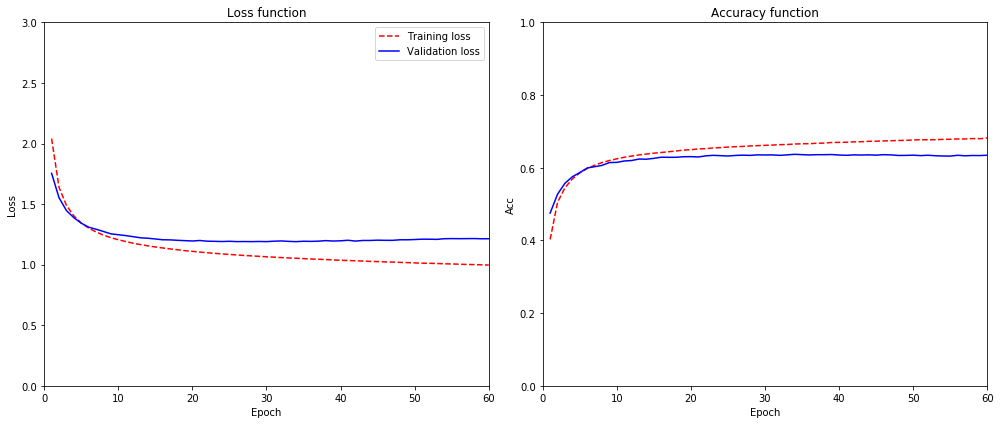

In [0]:
import matplotlib.pyplot as plt

training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

f = plt.figure(figsize=(14,6))

a0 = f.add_subplot(121)
a0.plot(epoch_count, training_loss, 'r--', label="Training loss")
a0.plot(epoch_count, validation_loss, 'b-', label="Validation loss")
a0.legend()
a0.set_title("Loss function")
a0.set_xlabel("Epoch")
plt.xlim(0, epochs)
a0.set_ylabel("Loss")
plt.ylim(0, np.ceil(max(training_loss)))

a1 = f.add_subplot(122)
a1.plot(epoch_count, training_acc, 'r--', label="Training acc")
a1.plot(epoch_count, validation_acc, 'b-', label="Validation acc")
a1.set_title("Accuracy function")
a1.set_xlabel("Epoch")
plt.xlim(0, epochs)
a1.set_ylabel("Acc")
plt.ylim(0, 1)
plt.savefig('chars_i40.png')

plt.tight_layout()
plt.show()

In [0]:
seed = dataset.get_random_sequence()
print("Generating with seed:", seed, "\n")
generate_text(model.model, seed, characters_amount=1000)

Generating with seed: sible, interwoven babble of shouts and r 

Generating with seed: "sible, interwoven babble of shouts and r"
Diversity: 0.2
sible, interwoven babble of shouts and read from the whole of the morning to the lawyer that the same time and the man was a large contact with the worse and did this of the stairs, he had not been the doorkeeper would not be able to go to him that he was almost been the most of the stairs, he would not be about the time of the corridor and the doorkeeper would have been able to do with the court officials and stood up to the court said the lawyer was so that he was already looked at the door of the stairs, and the man was the time to hear the lawyer was still had to be able to go to him to the bed called out with his hands and come to the court of the court.
 the man was too talking on the other hand, and then he was a secret of the steps to the door of the stairs, he had been able to do with the stairs, he was already least of the painter wa